A note on the ridge regression

jeremylhour

17/07/2024

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm.auto import tqdm

from scipy.stats import multivariate_normal
from sklearn.linear_model import Ridge

In [4]:
@dataclass
class DGP():
    """
    Generates synthetic data for illustrating the regularization bias.

    Args:
        n (int): Number of samples.
        p (int): Number of variables.
        r_y (float): R-squared for the outcome equation.
        rho (float): Covariate correlation parameter.

    Returns:
        tuple: A tuple containing the generated data:
            X (numpy.ndarray): Covariate matrix.
            y (numpy.ndarray): Outcome variable.
    """
    n: int = 1_000
    p: int = 500
    r_y: float = .1
    rho: float = .25
        
    def __post_init__(self):
        p = self.p
        # Covariate variance matrix
        self.sigma = np.array([[self.rho ** np.abs(k - j) for k in range(p)] for j in range(p)])

        # Coefficient
        beta = np.zeros(p)
        for j in range(p // 2):
            beta[j] = (-1) ** (j+1) / (j+1) ** 2

        # Adjustment to match R-squared
        beta *= np.sqrt(self.r_y / (1 - self.r_y) / (beta.T @ self.sigma @ beta))
        self.beta = beta
        
        # All even-indexed covariates are dummies
        self.even = np.arange(1, p + 1) % 2 == 0
    
    def generate(self):
        # Generate covariates
        X = multivariate_normal(mean=np.zeros(self.p), cov=self.sigma).rvs(size=self.n)
        X[:, self.even] = np.where(X[:, self.even] > 0, 1, 0)

        # Outcome
        y = X @ self.beta + np.random.randn(self.n)
        return X, y

In [32]:
dgp = DGP()
X, y = dgp.generate()
alpha_set = [10 ** i for i in range(-4, 6)]

# Functions
ridge_f = lambda x, alpha: x / (x ** 2 + alpha)
ols_inv = lambda x: 1 / x

# Penalty in the Ridge regression

Text(0.5, 1.0, 'Coefficient of first 10 features as alpha increases (log-scale)')

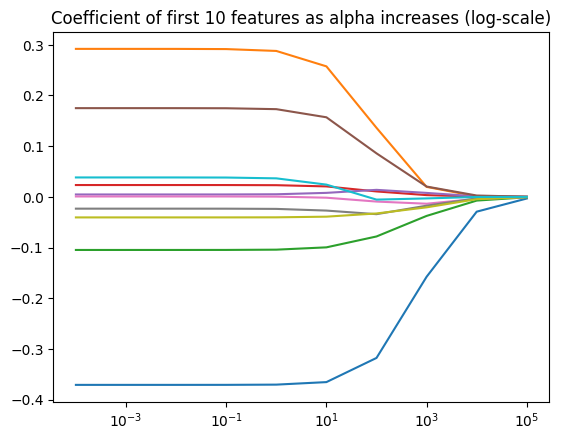

In [31]:
results = pd.DataFrame.from_dict({
    alpha: Ridge(alpha=alpha).fit(X, y).coef_ for alpha in alpha_set
}, orient='index')
results.index.names = ("alpha",)
results.columns.names = ("feature",)

plt.plot(results.iloc[:, :10])
plt.xscale('log')
plt.title("Coefficient of first 10 features as alpha increases (log-scale)")


# OLS, Ridge and Ridge-less regression

From lemma 2.1 in the book, we have :

When $\lambda \rightarrow 0$, the solution of the Ridge regression becomes the OLS using the pseudo-inverse of the covariance matrix:
\begin{equation*}
        \widehat \beta^R(\lambda) \rightarrow \left[ \frac{1}{n} \sum_{i=1}^n X_iX_i' \right]^{+} \frac{1}{n} \sum_{i=1}^n X_iY_i,
    \end{equation*}
where $\left[ \sum_{i=1}^n X_iX_i' /n\right]^{+}$ means the Moore-Penrose inverse of $ \sum_{i=1}^n X_iX_i'/n $. 

*Proof*:

From the SVD of $\boldsymbol{X} = \boldsymbol{U} \boldsymbol{S} \boldsymbol{V}'$ we get $\boldsymbol{X}'\boldsymbol{X} = \boldsymbol{V} \boldsymbol{S}' \boldsymbol{S}\boldsymbol{V}'$. So using matrix notations and the fact that $\boldsymbol{V}' \boldsymbol{V} = I_p$, we can write:
\begin{align*}
    \beta^R(\lambda) &= \left[ \boldsymbol{X}'\boldsymbol{X}  + \lambda I_p \right]^{-1} \boldsymbol{X}'\boldsymbol{y}\\
    &= \left[ \boldsymbol{V} \boldsymbol{S}'\boldsymbol{S} \boldsymbol{V}' + \lambda I_p \right]^{-1} \boldsymbol{V} \boldsymbol{S}' \boldsymbol{U}'\boldsymbol{y}\\
    &= \boldsymbol{V} \left[ \boldsymbol{S}'\boldsymbol{S} + \lambda I_p \right]^{-1} \boldsymbol{S}' \boldsymbol{U}'\boldsymbol{y}.
\end{align*}
Then because all these matrices are diagonal, we have:
\begin{equation*}
    \text{diag}\left( \left[ \boldsymbol{S}'\boldsymbol{S} + \lambda I_p \right]^{-1} \boldsymbol{S}' \right)= \left( \frac{s_j}{s_j^2 + \lambda}\right)_{j=1, \ldots, p}.
\end{equation*}
As $\lambda \rightarrow 0$, this last term is either equal to $s_j^{-1}$ if $s_j > 0$ or to 0 if $s_j = 0$. Hence, $\left[ \boldsymbol{S}'\boldsymbol{S} + \lambda I_p \right]^{-1} \boldsymbol{S}' \rightarrow \boldsymbol{S}^+$ and
\begin{align*}
    \beta^R(\lambda) \rightarrow  \boldsymbol{V} \boldsymbol{S}^+ \boldsymbol{U}'\boldsymbol{y} = \left[ \boldsymbol{X}'\boldsymbol{X}\right]^{+} \boldsymbol{X}'\boldsymbol{y}.
\end{align*}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


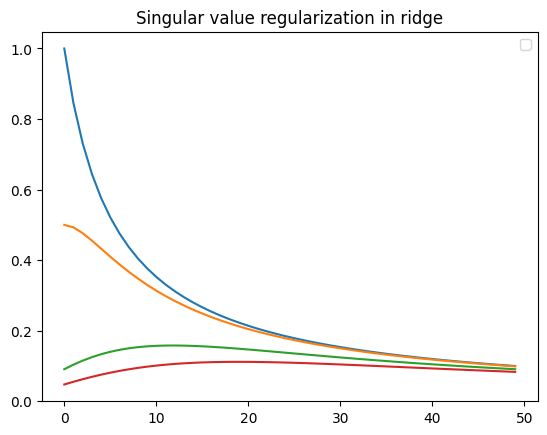

In [48]:
x = np.linspace(start=1, stop=10)

new_sv = pd.DataFrame.from_dict({
    'inverse': ols_inv(x),
    'ridge, alpha = 1': ridge_f(x, 1),
    'ridge, alpha = 10': ridge_f(x, 10),
    'ridge, alpha = 20': ridge_f(x, 20),
}, orient='columns')

plt.plot(new_sv)
plt.title("Singular value regularization in ridge")
plt.legend(loc='best')

In [49]:
u, s, vt = np.linalg.svd(X)

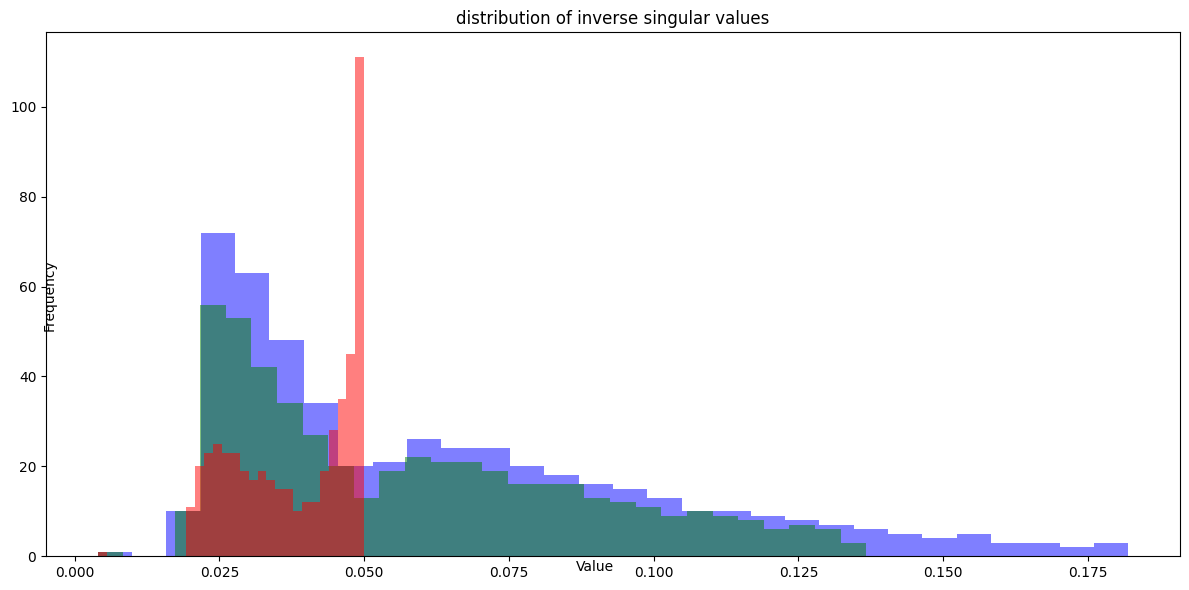

In [62]:
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 6))

# Plot the histograms
ax1.hist(ols_inv(s), bins=30, alpha=0.5, color='blue')
ax1.hist(ridge_f(s, alpha=10), bins=30, alpha=0.5, color='green')
ax1.hist(ridge_f(s, alpha=100), bins=30, alpha=0.5, color='red')

# Set titles
ax1.set_title('distribution of inverse singular values')

# Set common labels
fig.text(0.5, 0.04, 'Value', ha='center')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical')

# Display the plot
plt.tight_layout()
plt.show()